# Simple example of using the transmission_models library

In [10]:
from random import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
from scipy.stats import nbinom, gamma, binom, expon
from math import factorial
import time

import os,sys


In [11]:

sys.path.append('../')
import transmission_models as tmod
from utils import hierarchy_pos,hierarchy_pos_times,plot_transmision_network,tree_to_newick,search_firsts_sampled_siblings
from transmission_models.models import didelot_unsampled as du
import transmission_models.utils as utils
from transmission_models.models.topology_movements import *
import transmission_models.models.MCMC.MCMC  as MCMC

# Loading parameters

In [12]:
sampling_params = {
                    "pi":0.47,
                    "k_samp":5.316,
                    "theta_samp":1.158
                }
offspring_params = {
                    "r":4.47,
                    "p_inf":0.62,
                }
infection_params = {
                    "k_inf": 5.70959959960973,
                    "theta_inf":1.061661377840768
                }

In [13]:
# Creating the model
model = du(sampling_params, offspring_params, infection_params)

# Loading data

In [14]:
data_dir = "./data"
df = pd.read_csv(data_dir+"/49_nodes_icpmr_delta_gisaid.csv")
df['date_collection'] = pd.to_datetime(df['date_collection'])
df['date_submitted'] = pd.to_datetime(df['date_submitted'])
df["date_sample"] = (df["date_collection"]-df['date_collection'].min()).dt.days
df["t_inf_ini"] = df.apply(lambda row:row.date_sample-gamma.rvs(infection_params["k_inf"], loc=0, scale=infection_params["theta_inf"], size=1)[0] ,
                                       axis = 1)




In [15]:
# Generate a list of hosts from the dataframe
data = []
for i, h in enumerate(df.iloc):
    host = tmod.host(h.strain, i, t_sample=h.date_sample, t_inf=h.t_inf_ini)
    data.append(host)

# Generating initial condition network

In [16]:
#Generate a transmission tree with our dataset to initialize the MCMC

edge_list = []
K_dict = {h:model.samp_offspring() for h in data}

for i, h1 in enumerate(data[::-1]):
    P = 0
    event = False
    if i < 20:
        s = 0
    else:
        s = i
    K = model.samp_offspring()
    if K>0:
        for h2 in data[s::-1]:
            if int(h1) == int(h2):
                continue
            if K_dict[h2] == 0:
                continue
            if h1.t_inf > h2.t_inf:
                P_new = model.pdf_infection(h1.t_inf - h2.t_inf) 

                if P < P_new:
                    P = P_new
                    h2_infec = h2
                    K_dict[h2] -= 1
                    event = True
        if event: 
            edge_list.append((h2_infec, h1))
end_time = time.time()
model.T = nx.DiGraph()
model.T.add_edges_from(edge_list)

roots = [h for h in model.T if model.T.in_degree(h)==0]
t_min = min(roots, key=lambda h:h.t_inf).t_inf

model.root_host = tmod.host("Virtual_host",-1,t_inf=t_min-1.5*model.Delta_crit)

for h in roots:
    model.T.add_edge(model.root_host,h)

for h in [h for h in data if h not in model.T]:
    model.T.add_edge(model.root_host,h)

# MCMC with no location and genetic information

In [17]:
# Set up MCMC sampling parameters
mcmc = MCMC.MCMC(model)

In [21]:
# Set up MCMC sampling parameters
# N_burn: Number of initial iterations to discard (burn-in period)
# N_measure: Interval between measurements for collecting samples
# N_iter: Total number of iterations


N_burn = 2000
N_measure = 1000
N_iter = 20000

log_likelihoods = []
N_trees = []
N_unsampleds = []

for itt in range(N_iter):
    proposal,gg,pp,P,accepted,DL = mcmc.MCMC_iteration()
    if itt>N_burn and itt%N_measure==0:
        print(f"Iteration {itt}: log_likelihood={model.log_likelihood:.3f}, unsampled_hosts={len(model.unsampled_hosts)}, trees={len(search_firsts_sampled_siblings(model.root_host,model.T))}")
        log_likelihoods.append(model.log_likelihood)
        N_unsampleds.append(len(model.unsampled_hosts))        
        N_trees.append(len(search_firsts_sampled_siblings(model.root_host,model.T)))
    
    
    

Iteration 3000: log_likelihood=472.263, unsampled_hosts=20, trees=14
Iteration 4000: log_likelihood=496.162, unsampled_hosts=13, trees=16
Iteration 5000: log_likelihood=479.233, unsampled_hosts=18, trees=15
Iteration 6000: log_likelihood=495.014, unsampled_hosts=14, trees=13
Iteration 7000: log_likelihood=478.265, unsampled_hosts=17, trees=12
Iteration 8000: log_likelihood=476.173, unsampled_hosts=17, trees=13
Iteration 9000: log_likelihood=497.170, unsampled_hosts=12, trees=9
Iteration 10000: log_likelihood=489.875, unsampled_hosts=15, trees=7
Iteration 11000: log_likelihood=477.544, unsampled_hosts=15, trees=11
Iteration 12000: log_likelihood=503.353, unsampled_hosts=12, trees=11
Iteration 13000: log_likelihood=478.106, unsampled_hosts=14, trees=9
Iteration 14000: log_likelihood=476.109, unsampled_hosts=17, trees=13
Iteration 15000: log_likelihood=490.434, unsampled_hosts=15, trees=11
Iteration 16000: log_likelihood=478.321, unsampled_hosts=16, trees=13
Iteration 17000: log_likelihoo

Text(0.5, 0, 'log_likelihood')

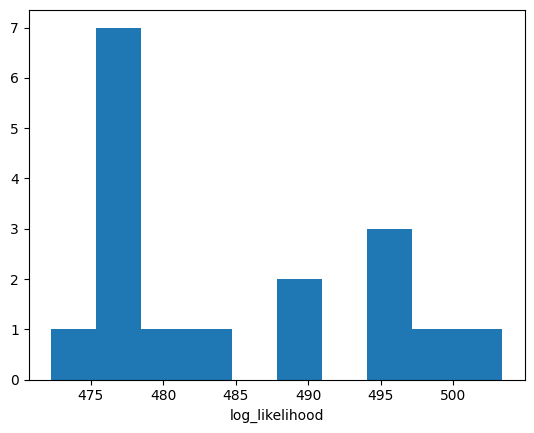

In [22]:
plt.hist(log_likelihoods)
plt.xlabel("log_likelihood")

Text(0.5, 0, 'Number of trees')

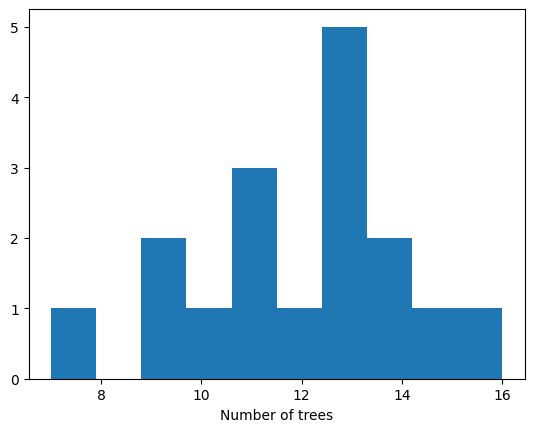

In [23]:
plt.hist(N_trees)
plt.xlabel("Number of trees")

Text(0.5, 0, 'Number of unsampled hosts')

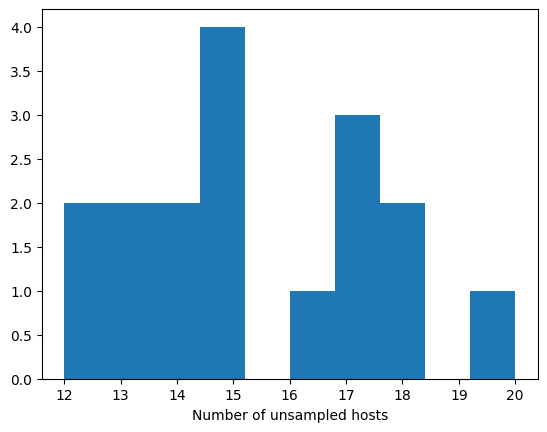

In [24]:
plt.hist(N_unsampleds)
plt.xlabel("Number of unsampled hosts")

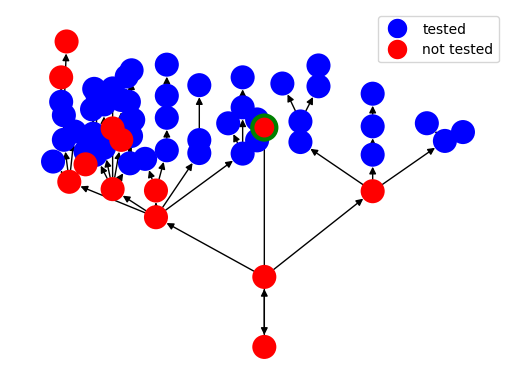

In [37]:
pos = hierarchy_pos_times(model.T, width=1., vert_gap=0.2, xcenter=0.5)

tmod.utils.plot_transmision_network(model.T,pos=pos,highlighted_nodes=[model.root_host])

In [36]:
def print_host_tree(host, T, pos, indent=""):
    """
    Recursively print the host, its position, and its children in a tree structure.
    
    Parameters
    ----------
    host : Host
        The current host to print
    T : nx.DiGraph
        The transmission tree
    pos : dict
        Dictionary containing positions for each host
    indent : str
        Indentation string for formatting the tree structure
    """
    print(f"{indent}Host: {host} - Position: {pos[host]}")
    
    # Get all children of the current host
    children = list(T.successors(host))
    
    for child in children:
        print_host_tree(child, T, pos, indent + "  ")

# Example usage:
print("Transmission tree structure:")
print_host_tree(model.root_host, model.T, pos)



Transmission tree structure:
Host: Virtual_host - Position: (0.5, 0)
  Host: U - Position: (0.5, -33.11747652292728)
    Host: U - Position: (0.5, -22.546682146802954)
      Host: U - Position: (0.25, -13.53855854412577)
        Host: U - Position: (0.05, -8.191614765231854)
          Host: hCoV-19/Australia/NSW1649/2021 - Position: (0.0125, -5.132251991570284)
          Host: hCoV-19/Australia/NSW1667/2021 - Position: (0.037500000000000006, -1.8490835809567434)
            Host: hCoV-19/Australia/NSW1677/2021 - Position: (0.037500000000000006, 1.8503968663768484)
              Host: hCoV-19/Australia/NSW1727/2021 - Position: (0.03125, 3.8856035637402098)
                Host: U - Position: (0.03125, 7.571811080194801)
              Host: U - Position: (0.04375, 12.992601937113573)
          Host: hCoV-19/Australia/NSW1664/2021 - Position: (0.0625, -0.6017395499483142)
          Host: U - Position: (0.0875, -5.553926771325283)
            Host: hCoV-19/Australia/NSW1678/2021 - Position

In [50]:
def hierarchy_pos_times(G, root=None, width=1., vert_gap=0.2, vert_loc=0, xcenter=0.5):
    """
    Compute hierarchical layout positions for a tree graph, using time as vertical position.

    Parameters
    ----------
    G : networkx.Graph
        The graph (must be a tree).
    root : node, optional
        The root node of the current branch. If None, the root will be found automatically.
    width : float, optional
        Horizontal space allocated for this branch. Default is 1.0.
    vert_gap : float, optional
        Gap between levels of hierarchy. Default is 0.2.
    vert_loc : float, optional
        Vertical location of root. Default is 0.
    xcenter : float, optional
        Horizontal location of root. Default is 0.5.

    Returns
    -------
    dict
        A dictionary of positions keyed by node.

    Notes
    -----
    This function is adapted from Joel's answer at https://stackoverflow.com/a/29597209/2966723.
    Licensed under Creative Commons Attribution-Share Alike.
    """
    if not nx.is_tree(G):
        raise TypeError('cannot use hierarchy_pos on a graph that is not a tree')

    if root is None:
        if isinstance(G, nx.DiGraph):
            root = next(iter(nx.topological_sort(G)))  # allows back compatibility with nx version 1.11
        else:
            root = random.choice(list(G.nodes))

    def _hierarchy_pos(G, root, width=1., vert_gap=0.2, vert_loc=0, xcenter=0.5, pos=None, parent=None):
        '''
        see hierarchy_pos docstring for most arguments

        pos: a dict saying where all nodes go if they have been assigned
        parent: parent of this branch. - only affects it if non-directed

        '''

        if pos is None:
            pos = {root: (xcenter, vert_loc)}
            print(f"Root: {root} - Position: {pos[root]}")
        else:
            pos[root] = (xcenter, vert_loc)
            print(f"Root: {root} - Position: {pos[root]}")
        children = list(G.neighbors(root))
        if not isinstance(G, nx.DiGraph) and parent is not None:
            children.remove(parent)
        if len(children) != 0:
            dx = width / len(children)
            nextx = xcenter - width / 2 - dx / 2
            for child in children:
                nextx += dx
                pos = _hierarchy_pos(G, child, width=dx, vert_gap=vert_gap,
                                     vert_loc=(pos[root][1]+(child.t_inf-root.t_inf)), xcenter=nextx,
                                     pos=pos, parent=root)
        return pos

    return _hierarchy_pos(G, root, width, vert_gap, vert_loc, xcenter)


Root: Virtual_host - Position: (0.5, 0)
Root: U - Position: (0.5, 4.372436872998335)
Root: U - Position: (0.5, 14.943231249122658)
Root: U - Position: (0.25, 23.95135485179984)
Root: U - Position: (0.05, 29.298298630693758)
Root: hCoV-19/Australia/NSW1649/2021 - Position: (0.0125, 32.357661404355326)
Root: hCoV-19/Australia/NSW1667/2021 - Position: (0.037500000000000006, 35.64082981496887)
Root: hCoV-19/Australia/NSW1677/2021 - Position: (0.037500000000000006, 39.34031026230246)
Root: hCoV-19/Australia/NSW1727/2021 - Position: (0.03125, 41.37551695966582)
Root: U - Position: (0.03125, 45.06172447612042)
Root: U - Position: (0.04375, 50.48251533303919)
Root: hCoV-19/Australia/NSW1664/2021 - Position: (0.0625, 36.8881738459773)
Root: U - Position: (0.0875, 31.93598662460033)
Root: hCoV-19/Australia/NSW1678/2021 - Position: (0.0875, 33.86373549262025)
Root: U - Position: (0.15000000000000002, 28.192266100732727)
Root: hCoV-19/Australia/NSW1662/2021 - Position: (0.11000000000000003, 33.348

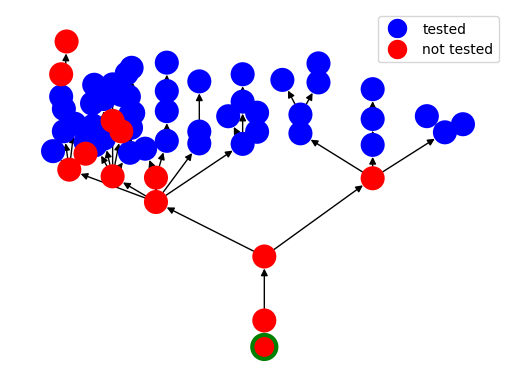

In [51]:
pos = hierarchy_pos_times(model.T, width=1., vert_gap=0.2, xcenter=0.5)

tmod.utils.plot_transmision_network(model.T,pos=pos,highlighted_nodes=[model.root_host])





# MCMC with location information

To add location to the model you need a 2d array indexed with the id of the hosts and add it to the model with the `add_same_location_prior` method.

In [ ]:
# Creating the 2d array of distances between hosts
dist_df = pd.read_csv("./data/location_49_hosts.tsv",sep="\t", index_col="strain_x")


dist_loc = np.zeros((len(model.T),len(model.T)))
i=0
for h in model.T:
    if not h.sampled: continue
    if str(h) not in dist_df.index:
            dist_loc[int(h), :] = None
            dist_loc[:,int(h)] = None
            continue
    for h2 in model.T[h]:
        if str(h2) not in dist_df.index:
            dist_loc[int(h2), :] = None
            dist_loc[:,int(h2)] = None
            continue
        if not h2.sampled: continue
        i+=1
        dist_loc[int(h),int(h2)] = dist_df.loc[str(h),str(h2)]
        dist_loc[int(h2),int(h)] = dist_df.loc[str(h2),str(h)]

# Adding the location to the model
model.add_same_location_prior(0.1,15,dist_loc)
model.same_location_log_prior = model.same_location_prior.log_prior_T(model.T)

hCoV-19/Australia/NSW1634/2021
hCoV-19/Australia/NSW1668/2021
hCoV-19/Australia/NSW1666/2021
hCoV-19/Australia/NSW1705/2021
hCoV-19/Australia/NSW1762/2021
hCoV-19/Australia/NSW1732/2021
hCoV-19/Australia/NSW1761/2021
hCoV-19/Australia/NSW1703/2021
hCoV-19/Australia/NSW1760/2021
hCoV-19/Australia/NSW1643/2021
hCoV-19/Australia/NSW1748/2021
hCoV-19/Australia/NSW1661/2021
hCoV-19/Australia/NSW1743/2021
hCoV-19/Australia/NSW1656/2021
hCoV-19/Australia/NSW1739/2021
hCoV-19/Australia/NSW1672/2021
hCoV-19/Australia/NSW1662/2021
hCoV-19/Australia/NSW1729/2021
hCoV-19/Australia/NSW1660/2021
hCoV-19/Australia/NSW1728/2021
hCoV-19/Australia/NSW1727/2021
hCoV-19/Australia/NSW1713/2021
hCoV-19/Australia/NSW1708/2021
hCoV-19/Australia/NSW1680/2021
hCoV-19/Australia/NSW1678/2021
hCoV-19/Australia/NSW1652/2021
hCoV-19/Australia/NSW1658/2021
hCoV-19/Australia/NSW1665/2021
Virtual_host
hCoV-19/Australia/NSW1649/2021
hCoV-19/Australia/NSW1657/2021
hCoV-19/Australia/NSW1677/2021
hCoV-19/Australia/NSW1679/

In [ ]:
mcmc = MCMC.MCMC(model)
# Set up MCMC sampling parameters
# N_burn: Number of initial iterations to discard (burn-in period)
# N_measure: Interval between measurements for collecting samples
# N_iter: Total number of iterations

N_burn = 2000
N_measure = 100

log_likelihoods = []
N_trees = []
N_unsampleds = []

for itt in range(20000):
    proposal,gg,pp,P,accepted,DL = mcmc.MCMC_iteration()
    if itt>N_burn and itt%N_measure==0:
        log_likelihoods.append(model.log_likelihood+model.same_location_log_prior)
        N_unsampleds.append(len(model.unsampled_hosts))        
        N_trees.append(len(search_firsts_sampled_siblings(model.root_host,model.T)))
    
    
    

Text(0.5, 0, 'log_likelihood')

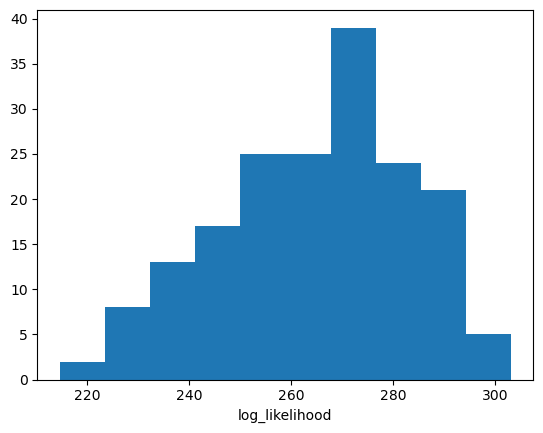

In [ ]:
plt.hist(log_likelihoods)
plt.xlabel("log_likelihood")

Text(0.5, 0, 'Number of trees')

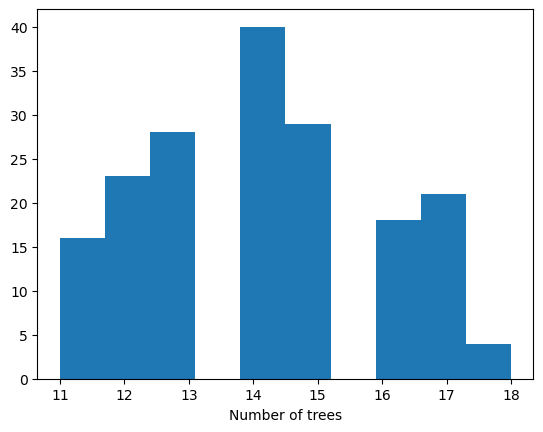

In [ ]:
plt.hist(N_trees)
plt.xlabel("Number of trees")

Text(0.5, 0, 'Number of unsampled hosts')

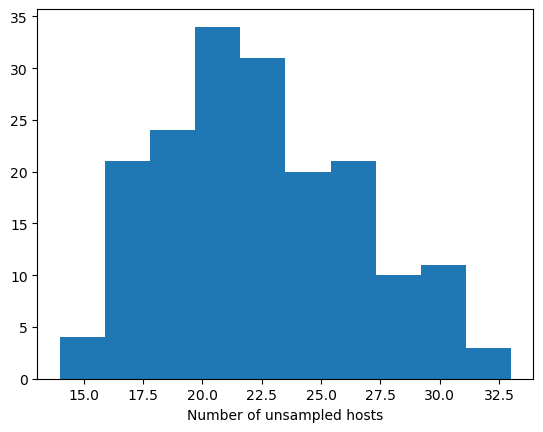

In [ ]:
plt.hist(N_unsampleds)
plt.xlabel("Number of unsampled hosts")

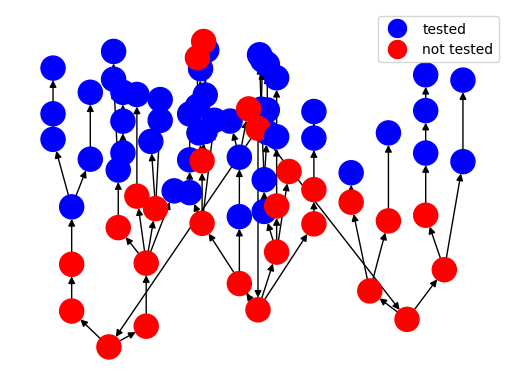

In [ ]:
pos = hierarchy_pos_times(model.T, root=model.root_host, width=1., vert_gap=0.2, vert_loc=0, xcenter=0.5)

tmod.utils.plot_transmision_network(model.T,pos=pos)

In [ ]:
dist_df

,hCoV-19/Australia/NSW1649/2021,hCoV-19/Australia/NSW1634/2021,hCoV-19/Australia/NSW1643/2021,hCoV-19/Australia/NSW1654/2021,hCoV-19/Australia/NSW1656/2021,hCoV-19/Australia/NSW1661/2021,hCoV-19/Australia/NSW1657/2021,hCoV-19/Australia/NSW1660/2021,hCoV-19/Australia/NSW1662/2021,hCoV-19/Australia/NSW1672/2021,...,hCoV-19/Australia/NSW1667/2021,hCoV-19/Australia/NSW1773/2021,hCoV-19/Australia/NSW1663/2021,hCoV-19/Australia/NSW1781/2021,hCoV-19/Australia/NSW1782/2021,hCoV-19/Australia/NSW1785/2021,hCoV-19/Australia/NSW1793/2021,hCoV-19/Australia/NSW1655/2021,hCoV-19/Australia/NSW1658/2021,hCoV-19/Australia/NSW1666/2021
strain_x,,,,,,,,,,,,,,,,,,,,,
hCoV-19/Australia/NSW1649/2021,0.00,0.01,0.00,0.01,0.01,0.00,0.00,0.00,0.00,0.00,...,0.00,0.01,0.03,0.01,0.01,0.01,0.01,0.01,0.00,0.02
hCoV-19/Australia/NSW1634/2021,0.01,0.00,0.00,0.01,0.01,0.00,0.00,0.00,0.00,0.00,...,0.00,0.01,0.04,0.01,0.01,0.00,0.00,0.01,0.01,0.03
hCoV-19/Australia/NSW1643/2021,0.00,0.00,0.00,0.01,0.01,0.00,0.00,0.00,0.00,0.00,...,0.00,0.01,0.03,0.01,0.01,0.00,0.00,0.01,0.00,0.03
hCoV-19/Australia/NSW1654/2021,0.01,0.01,0.01,0.00,0.02,0.01,0.01,0.01,0.01,0.01,...,0.00,0.01,0.03,0.01,0.01,0.01,0.01,0.01,0.00,0.03
hCoV-19/Australia/NSW1656/2021,0.01,0.01,0.01,0.02,0.00,0.01,0.01,0.01,0.01,0.01,...,0.01,0.02,0.04,0.02,0.02,0.01,0.01,0.01,0.01,0.02
hCoV-19/Australia/NSW1661/2021,0.00,0.00,0.00,0.01,0.01,0.00,0.00,0.00,0.00,0.00,...,0.00,0.01,0.03,0.01,0.01,0.00,0.00,0.01,0.00,0.03
hCoV-19/Australia/NSW1657/2021,0.00,0.00,0.00,0.01,0.01,0.00,0.00,0.00,0.00,0.00,...,0.00,0.01,0.03,0.01,0.01,0.00,0.00,0.01,0.00,0.03
hCoV-19/Australia/NSW1660/2021,0.00,0.00,0.00,0.01,0.01,0.00,0.00,0.00,0.00,0.00,...,0.00,0.01,0.03,0.01,0.01,0.00,0.00,0.01,0.00,0.03
hCoV-19/Australia/NSW1662/2021,0.00,0.00,0.00,0.01,0.01,0.00,0.00,0.00,0.00,0.00,...,0.00,0.01,0.04,0.01,0.01,0.00,0.00,0.01,0.00,0.03


In [ ]:
data_dir = "./data/genetic_49_hosts.tsv"
dist_df = pd.read_csv(data_dir,sep="\t",index_col=0)
dist_gen = np.zeros((len(model.T),len(model.T)))
i = 0
for h in model.T:
    if not h.sampled: continue
    for h2 in model.T[h]:
        if not h2.sampled: continue
        i+=1
        print(i,h,h2)
        dist_gen[int(h),int(h2)] = dist_df.loc[h.id,h2.id]
        dist_gen[int(h2),int(h)] = dist_df.loc[h2.id,h.id]

model.add_genetic_prior(0.1065,dist_gen)
model.genetic_log_prior = model.genetic_prior.log_prior_T(model.T)

1 hCoV-19/Australia/NSW1634/2021 hCoV-19/Australia/NSW1729/2021
2 hCoV-19/Australia/NSW1634/2021 hCoV-19/Australia/NSW1654/2021
3 hCoV-19/Australia/NSW1666/2021 hCoV-19/Australia/NSW1738/2021
4 hCoV-19/Australia/NSW1732/2021 hCoV-19/Australia/NSW1713/2021
5 hCoV-19/Australia/NSW1703/2021 hCoV-19/Australia/NSW1660/2021
6 hCoV-19/Australia/NSW1703/2021 hCoV-19/Australia/NSW1773/2021
7 hCoV-19/Australia/NSW1643/2021 hCoV-19/Australia/NSW1652/2021
8 hCoV-19/Australia/NSW1748/2021 hCoV-19/Australia/NSW1680/2021
9 hCoV-19/Australia/NSW1748/2021 hCoV-19/Australia/NSW1708/2021
10 hCoV-19/Australia/NSW1661/2021 hCoV-19/Australia/NSW1748/2021
11 hCoV-19/Australia/NSW1743/2021 hCoV-19/Australia/NSW1785/2021
12 hCoV-19/Australia/NSW1656/2021 hCoV-19/Australia/NSW1705/2021
13 hCoV-19/Australia/NSW1739/2021 hCoV-19/Australia/NSW1728/2021
14 hCoV-19/Australia/NSW1672/2021 hCoV-19/Australia/NSW1663/2021
15 hCoV-19/Australia/NSW1662/2021 hCoV-19/Australia/NSW1743/2021
16 hCoV-19/Australia/NSW1662/2021 

In [ ]:
mcmc = MCMC.MCMC(model)

In [ ]:
N_burn = 2000
N_measure = 100

log_likelihoods = []
N_trees = []
N_unsampleds = []

for itt in range(20000):
    proposal,gg,pp,P,accepted,DL = mcmc.MCMC_iteration()
    if itt>N_burn and itt%N_measure==0:
        log_likelihoods.append(model.log_likelihood)
        N_unsampleds.append(len(model.unsampled_hosts))        
        N_trees.append(len(search_firsts_sampled_siblings(model.root_host,model.T)))
    
    
    

Text(0.5, 0, 'log_likelihood')

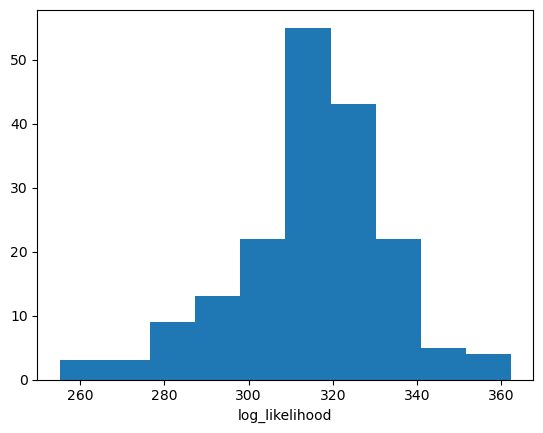

In [ ]:
plt.hist(log_likelihoods)
plt.xlabel("log_likelihood")

Text(0.5, 0, 'Number of trees')

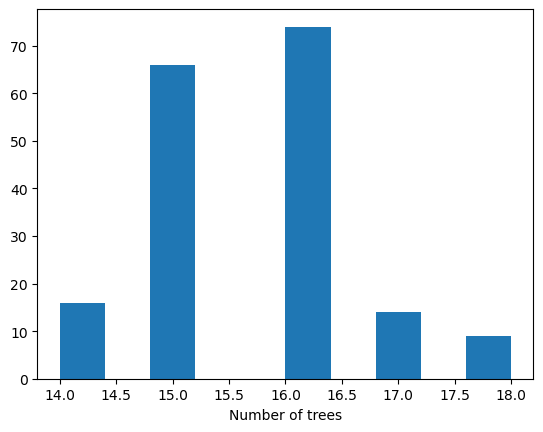

In [ ]:
plt.hist(N_trees)
plt.xlabel("Number of trees")

Text(0.5, 0, 'Number of unsampled hosts')

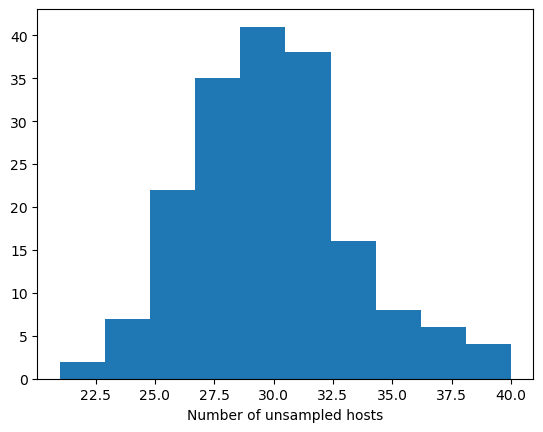

In [ ]:
plt.hist(N_unsampleds)
plt.xlabel("Number of unsampled hosts")

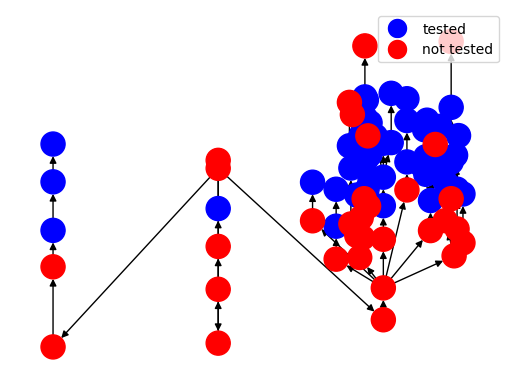

In [ ]:
pos = hierarchy_pos_times(model.T, root=model.root_host, width=1., vert_gap=0.2, vert_loc=0, xcenter=0.5)

tmod.utils.plot_transmision_network(model.T,pos=pos)